In [76]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

In [79]:
data = pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
age         1025 non-null int64
sex         1025 non-null int64
cp          1025 non-null int64
trestbps    1025 non-null int64
chol        1025 non-null int64
fbs         1025 non-null int64
restecg     1025 non-null int64
thalach     1025 non-null int64
exang       1025 non-null int64
oldpeak     1025 non-null float64
slope       1025 non-null int64
ca          1025 non-null int64
thal        1025 non-null int64
target      1025 non-null int64
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [81]:
data = data.dropna()

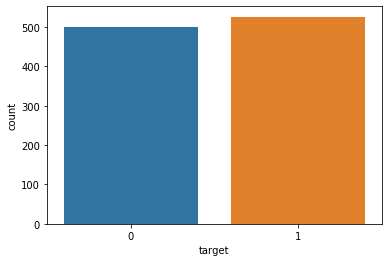

In [82]:
sns.countplot(x=data['target'])

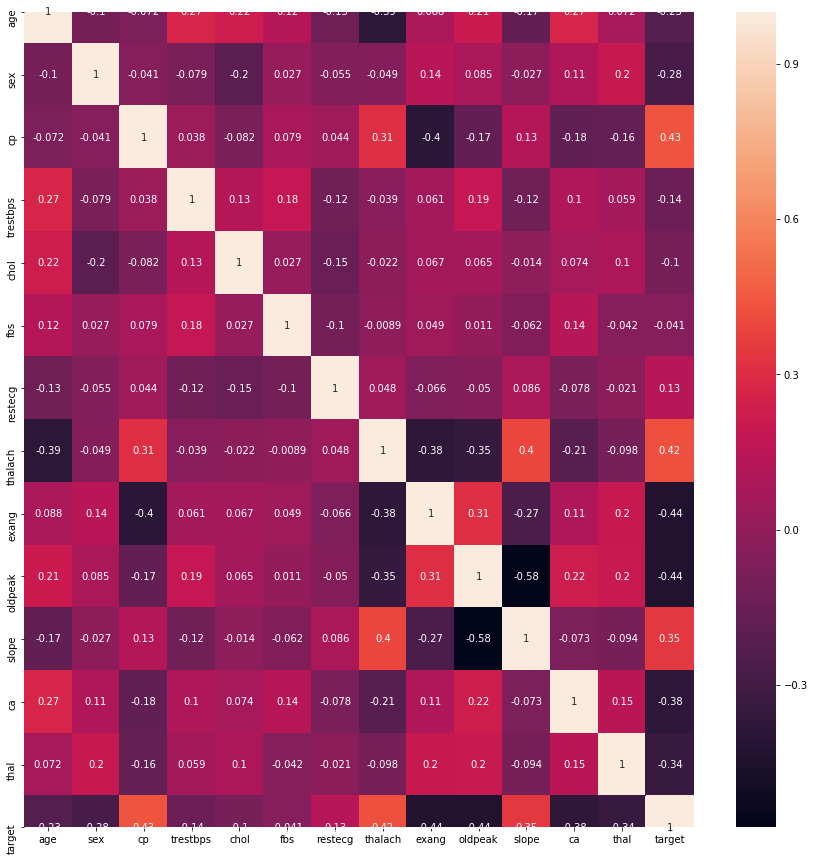

In [83]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [84]:
X = data.drop(["target"],axis =1)
y = data["target"]

# Feature Engineering

In [85]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
rfecv = RFECV(cv=11, estimator=RandomForestClassifier(random_state=0),
      scoring='accuracy')

In [86]:
rfecv.fit(X,y)

RFECV(cv=11, estimator=RandomForestClassifier(random_state=0),
      scoring='accuracy')

In [87]:
#to get number of the features
display('Number of features:', rfecv.n_features_)

#to get feature names
list(X.columns[rfecv.support_]) 

'Number of features:'

8

['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']

In [88]:
X_fe = data[['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']]

# PC - Heart Failure

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 8)

x_pca = pca.fit_transform(X_fe)

In [90]:
x_pca.shape

(1025, 8)

In [91]:
x_pca

array([[-34.6134893 , -18.61896596,  -2.95938327, ...,  -1.26361176,
          0.18405391,  -0.49047147],
       [-42.62662174,  -4.18089964,  10.99496101, ...,   0.82126433,
         -1.57509571,  -0.41531675],
       [-70.20160302,  29.34943055,  16.30737271, ...,   0.56332711,
         -1.67353233,  -0.55010646],
       ...,
       [ 27.99632937,  26.6437281 , -27.15221246, ...,  -0.53656787,
          0.08199777,   0.40548151],
       [  6.58865617, -12.52011982, -21.19461765, ...,  -0.79270423,
         -0.93684794,   0.26001829],
       [-57.96015356,  35.82239743, -12.38472877, ...,  -0.45106542,
         -0.23535768,  -0.61374537]])

Text(0, 0.5, 'Second Principal Component')

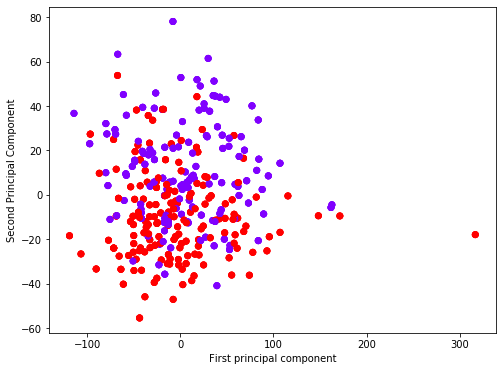

In [92]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=data['target'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [93]:
df = data[['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal','target']]
df.to_csv('processed.csv')

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((820, 8), (820,), (205, 8), (205,))

In [95]:
ML_Model = []
accuracy = []
f1score = []
recall = []
precision = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    f1score.append(round(b, 3))
    recall.append(round(c, 3))
    precision.append(round(d, 3))

In [96]:
ML_Model1 = []
mean = []

#function to call for storing the results
def storeResults1(model, a):
    ML_Model1.append(model)
    mean.append(round(a, 3))

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [98]:
class StackingEnsemble:
    def __init__(self, base_models, final_model, k=5):
        self.base_models = base_models
        self.final_model = final_model
        self.k = k
        self.train_meta_model = None
        self.test_meta_model = None

    def k_fold_cross_validation(self, clf, X_train, y_train):
        predictions_clf = None
        kf = KFold(n_splits=self.k)
        for train_index, test_index in kf.split(X_train):
            fold_x_train, fold_x_test = X_train[train_index], X_train[test_index]
            fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]
            clf.fit(fold_x_train, fold_y_train)
            fold_y_pred = clf.predict(fold_x_test)
            if predictions_clf is None:
                predictions_clf = fold_y_pred
            else:
                predictions_clf = np.concatenate((predictions_clf, fold_y_pred))
        return predictions_clf

    def train_level_0(self, clf, X_train, X_test, y_train):
        clf.fit(X_train, y_train)
        return clf.predict(X_test)

    def fit(self, X_train, X_test, y_train):
        for clf in self.base_models:
            predictions_clf = self.k_fold_cross_validation(clf, X_train, y_train)
            test_predictions_clf = self.train_level_0(clf, X_train, X_test, y_train)
            if self.train_meta_model is None:
                self.train_meta_model = predictions_clf
                self.test_meta_model = test_predictions_clf
            else:
                self.train_meta_model = np.vstack((self.train_meta_model, predictions_clf))
                self.test_meta_model = np.vstack((self.test_meta_model, test_predictions_clf))
        self.train_meta_model = self.train_meta_model.T
        self.test_meta_model = self.test_meta_model.T
        self.final_model.fit(self.train_meta_model, y_train)

    def predict(self):
        return self.final_model.predict(self.test_meta_model)

# Logistic Regression

In [99]:
# Logistic Regression model 
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline

# instantiate the model
log = LogisticRegression(penalty='l2', fit_intercept=True, random_state = 1, max_iter =100)

log.fit(X_train,y_train)

y_pred = log.predict(X_test)

lr_acc = accuracy_score(y_pred, y_test)
lr_prec = precision_score(y_pred, y_test)
lr_rec = recall_score(y_pred, y_test)
lr_f1 = f1_score(y_pred, y_test)

storeResults('Logistic Regression',lr_acc,lr_prec,lr_rec,lr_f1)

In [100]:
from sklearn.model_selection import KFold   
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(log, X_train, y_train, cv = k_fold)

mean_lr = sum(score) / len(score)

storeResults1('Logistic Regression K-Fold',mean_lr)

# Decision Tree

In [101]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(criterion='gini',max_depth=300,min_samples_split=2,max_features=None,random_state=0,max_leaf_nodes=None)#,alpha=0.0)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

dt_acc = accuracy_score(y_pred, y_test)
dt_prec = precision_score(y_pred, y_test)
dt_rec = recall_score(y_pred, y_test)
dt_f1 = f1_score(y_pred, y_test)

storeResults('Decision Tree',dt_acc,dt_prec,dt_rec,dt_f1)

In [102]:
from sklearn.model_selection import KFold   
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(tree, X_train, y_train, cv = k_fold)

mean_dt = sum(score) / len(score)
#mean_dt
storeResults1('Decision Tree K-Fold',mean_dt)

# Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_depth=300,  max_features='sqrt',
                           bootstrap = True, random_state = 0, max_samples = None)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_pred, y_test)
rf_prec = precision_score(y_pred, y_test)
rf_rec = recall_score(y_pred, y_test)
rf_f1 = f1_score(y_pred, y_test)

storeResults('Random Forest',rf_acc,rf_prec,rf_rec,rf_f1)

In [104]:
from sklearn.model_selection import KFold   
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(rf, X_train, y_train, cv = k_fold)

mean_rf = sum(score) / len(score)
#mean_rf
storeResults1('Random Forest K-Fold',mean_rf)

# SVM

In [105]:
from sklearn.svm import SVC

# instantiate the model 
svm = SVC(C=1.0,kernel = 'rbf', degree = 3, gamma = 'scale', probability=True, tol = 0.001,cache_size=200,max_iter=-1,random_state=0)

# fit the model 
svm.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm.predict(X_test)

svc_acc = accuracy_score(y_pred, y_test)
svc_prec = precision_score(y_pred, y_test)
svc_rec = recall_score(y_pred, y_test)
svc_f1 = f1_score(y_pred, y_test)

storeResults('Support Vector Machine',svc_acc,svc_prec,svc_rec,svc_f1)

In [106]:
from sklearn.model_selection import KFold   
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(svm, X_train, y_train, cv = k_fold)

mean_svm = sum(score) / len(score)
#mean_rf
storeResults1('SVM K-Fold',mean_svm)

# KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.pipeline import Pipeline

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto',leaf_size=30, p=2, metric='minkowski')

# fit the model 
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

knn_acc = accuracy_score(y_pred, y_test)
knn_prec = precision_score(y_pred, y_test)
knn_rec = recall_score(y_pred, y_test)
knn_f1 = f1_score(y_pred, y_test)

storeResults('KNN',knn_acc,knn_prec,knn_rec,knn_f1)

In [108]:
k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(knn, X_train, y_train, cv = k_fold)

mean_knn = sum(score) / len(score)
#mean_rf
storeResults1('KNN K-Fold',mean_knn)

# MLP

In [109]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (5,2),activation='relu',solver = 'lbfgs', alpha = 0.0001,
                      learning_rate = 'constant',random_state=1, max_iter=300, shuffle = True)
# fit the model 
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mlp_acc = accuracy_score(y_pred, y_test)
mlp_prec = precision_score(y_pred, y_test)
mlp_rec = recall_score(y_pred, y_test)
mlp_f1 = f1_score(y_pred, y_test)

storeResults('MLP',mlp_acc,mlp_prec,mlp_rec,mlp_f1)

In [110]:
k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(model, X_train, y_train, cv = k_fold)

mean_mlp = sum(score) / len(score)
#mean_rf
storeResults1('MLP K-Fold',mean_mlp)

# Naive Bayes

In [111]:
# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB

# instantiate the model
nb=  GaussianNB(var_smoothing=1e-09)

# fit the model 
nb.fit(X_train,y_train)

y_pred = nb.predict(X_test)

nb_acc = accuracy_score(y_pred, y_test)
nb_prec = precision_score(y_pred, y_test)
nb_rec = recall_score(y_pred, y_test)
nb_f1 = f1_score(y_pred, y_test)

storeResults('Naive Bayes',nb_acc,nb_prec,nb_rec,nb_f1)

In [112]:
k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(nb, X_train, y_train, cv = k_fold)

mean_nb = sum(score) / len(score)
#mean_rf
storeResults1('Naive Bayes K-Fold',mean_nb)

# XGBoost

In [113]:
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(loss='log_loss', learning_rate=0.1, n_estimators = 100, min_samples_split = 2,
                   min_samples_leaf =1, max_depth = 3, use_label_encoder = False, eval_metric = 'mlogloss')

# fit the model 
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

xgb_acc = accuracy_score(y_pred, y_test)
xgb_prec = precision_score(y_pred, y_test)
xgb_rec = recall_score(y_pred, y_test)
xgb_f1 = f1_score(y_pred, y_test)

storeResults('XGBoost',xgb_acc,xgb_prec,xgb_rec,xgb_f1)

[11:19:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [114]:
k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(xgb, X_train, y_train, cv = k_fold)

mean_xgb = sum(score) / len(score)
#mean_rf
storeResults1('XGBoost K-Fold',mean_xgb)

[11:19:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:19:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:19:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner

# Gradient Boosting

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
gbc = GradientBoostingClassifier(learning_rate = 1.0, n_estimators = 20, subsample = 1.0,
                                criterion = 'friedman_mse', max_depth = 2, random_state = 1)

# fit the model 
gbc.fit(X_train,y_train)

y_pred = gbc.predict(X_test)

gb_acc = accuracy_score(y_pred, y_test)
gb_prec = precision_score(y_pred, y_test)
gb_rec = recall_score(y_pred, y_test)
gb_f1 = f1_score(y_pred, y_test)

storeResults('Gradient Boosting',gb_acc,gb_prec,gb_rec,gb_f1)

In [116]:
k_fold = KFold(n_splits = 10, random_state = None)
score = cross_val_score(gbc, X_train, y_train, cv = k_fold)

mean_gb = sum(score) / len(score)
#mean_rf
storeResults1('Gradient Boosting K-Fold',mean_gb)

# Stacking Classifier

>lr 0.844 (0.033)
>knn 0.751 (0.033)
>dt 0.999 (0.005)
>svm 0.706 (0.043)
>bayes 0.824 (0.045)
>stacking 0.999 (0.005)


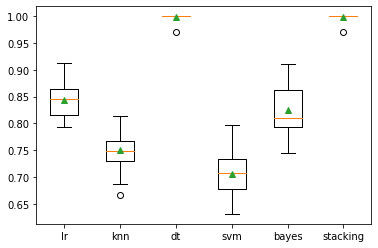

In [117]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot as plt

def load_heart_failure_data():
    df = pd.read_csv('heart.csv')
    
    X = df.iloc[:, :-1]  
    y = df.iloc[:, -1]   
    return X, y

def get_base_models():
    models = [
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('svm', SVC()),
        ('bayes', GaussianNB())
    ]
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def main():
    X, y = load_heart_failure_data()

    base_models = get_base_models()

    results, names = list(), list()
    for name, model in base_models:
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

    stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

    stacking_scores = evaluate_model(stacking_classifier, X, y)
    results.append(stacking_scores)
    names.append('stacking')
    print('>%s %.3f (%.3f)' % ('stacking', np.mean(stacking_scores), np.std(stacking_scores)))

    plt.boxplot(results, labels=names, showmeans=True)
    plt.show()


if __name__ == "__main__":
    main()


# Comparison

In [118]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1score,
                        'Recall'   : recall,
                        'Precision': precision
                      })

In [119]:
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,Logistic Regression,0.751,0.816,0.724,0.767
1,Decision Tree,0.985,0.971,1.000,0.985
2,Random Forest,0.971,0.942,1.000,0.970
3,Support Vector Machine,0.639,0.660,0.636,0.648
4,KNN,0.902,0.913,0.895,0.904
5,MLP,0.610,0.223,1.000,0.365
6,Naive Bayes,0.751,0.777,0.741,0.758
7,XGBoost,0.912,0.913,0.913,0.913
8,Gradient Boosting,0.922,0.922,0.922,0.922


In [120]:
#creating dataframe
result1 = pd.DataFrame({ 'ML Model' : ML_Model1,
                        'Accuracy' : mean,
                      })
result1

,ML Model,Accuracy
0,Logistic Regression K-Fold,0.833
1,Decision Tree K-Fold,0.985
2,Random Forest K-Fold,0.989
3,SVM K-Fold,0.720
4,KNN K-Fold,0.872
5,MLP K-Fold,0.716
6,Naive Bayes K-Fold,0.828
7,XGBoost K-Fold,0.955
8,Gradient Boosting K-Fold,0.959


# Graph

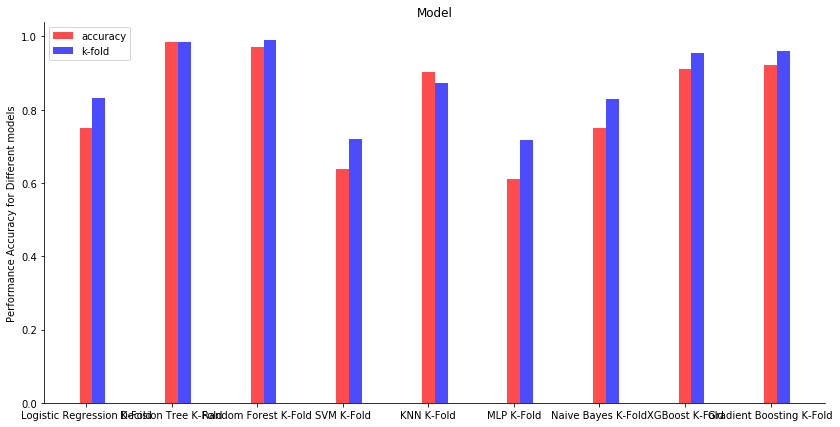

In [121]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ML_Model
values = accuracy
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ML_Model1
values = mean
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'k-fold')
plt.xticks(model, models)




plt.ylabel('Performance Accuracy for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()           


In [122]:
classifier = ML_Model1
y_pos = np.arange(len(classifier))

# K-Fold Accuracy Comparison

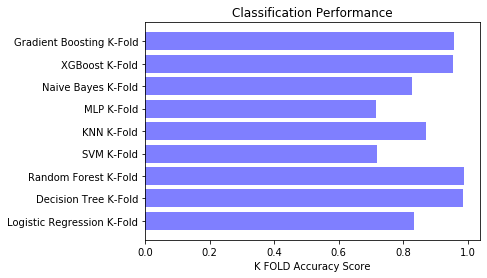

In [123]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, mean, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('K FOLD Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

In [124]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

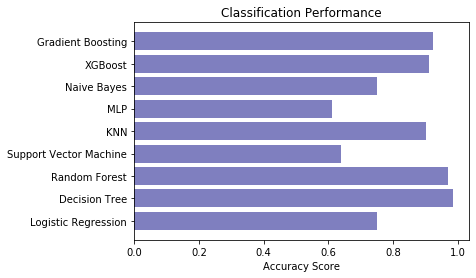

In [125]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

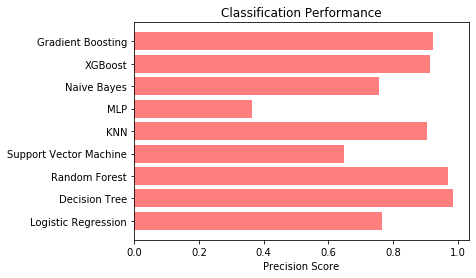

In [126]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

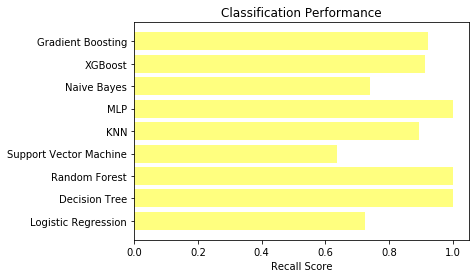

In [127]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

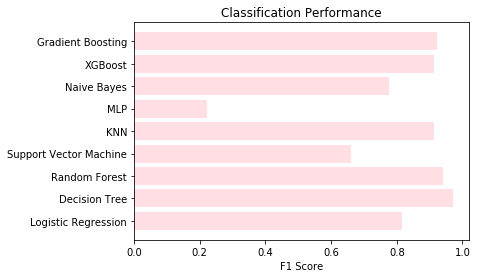

In [128]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# Modelling for Frontend with Selected Features

In [129]:
data = pd.read_csv("processed.csv")
data.head()

,Unnamed: 0,age,cp,trestbps,chol,thalach,oldpeak,ca,thal,target
0,0,52,0,125,212,168,1.0,2,3,0
1,1,53,0,140,203,155,3.1,0,3,0
2,2,70,0,145,174,125,2.6,0,3,0
3,3,61,0,148,203,161,0.0,1,3,0
4,4,62,0,138,294,106,1.9,3,2,0


In [130]:
del data['Unnamed: 0']

In [131]:
X = data.drop(["target"],axis =1)
y = data["target"]

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [133]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

In [134]:
import joblib
filename = 'model.sav'
joblib.dump(tree, filename)

['model.sav']